In [4]:
!unzip -qq archive_2.zip

Creating Train,validation and test sub directries

In [50]:
import os, shutil, pathlib

original_dir = pathlib.Path("./train/train/")
new_base_dir = pathlib.Path("./cats_vs_dogs_5000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=5000)
make_subset("validation", start_index=5000, end_index=5500)
make_subset("test", start_index=5500, end_index=6000)

Preprocessing Data

In [51]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(150, 150),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(150, 150),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(150, 150),
    batch_size=32)

Found 10000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [52]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [53]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [54]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [55]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [56]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)


Building the model

In [57]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(150, 150, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Model summary

In [58]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_5 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                      

In [59]:
model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [60]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
313/313 [==============================] - 16s 44ms/step - loss: 0.6625 - accuracy: 0.5918 - val_loss: 0.6181 - val_accuracy: 0.6630
Epoch 2/30
313/313 [==============================] - 14s 44ms/step - loss: 0.5753 - accuracy: 0.6985 - val_loss: 0.5407 - val_accuracy: 0.7040
Epoch 3/30
313/313 [==============================] - 14s 44ms/step - loss: 0.5022 - accuracy: 0.7561 - val_loss: 0.5625 - val_accuracy: 0.7250
Epoch 4/30
313/313 [==============================] - 16s 50ms/step - loss: 0.4468 - accuracy: 0.7894 - val_loss: 0.4347 - val_accuracy: 0.7990
Epoch 5/30
313/313 [==============================] - 14s 44ms/step - loss: 0.3866 - accuracy: 0.8238 - val_loss: 0.3965 - val_accuracy: 0.8260
Epoch 6/30
313/313 [==============================] - 14s 44ms/step - loss: 0.3180 - accuracy: 0.8623 - val_loss: 0.3664 - val_accuracy: 0.8250
Epoch 7/30
313/313 [==============================] - 14s 44ms/step - loss: 0.2568 - accuracy: 0.8943 - val_loss: 0.3672 - val_accuracy:

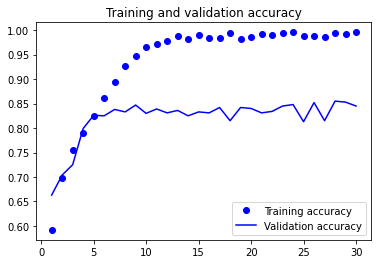

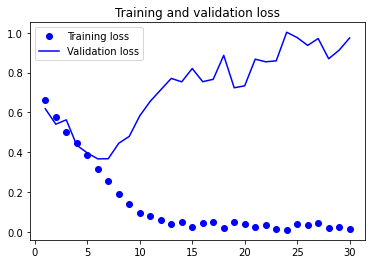

In [61]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [62]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 26ms/step - loss: 0.3903 - accuracy: 0.8350
Test accuracy: 0.835


Using Augmentation

In [63]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

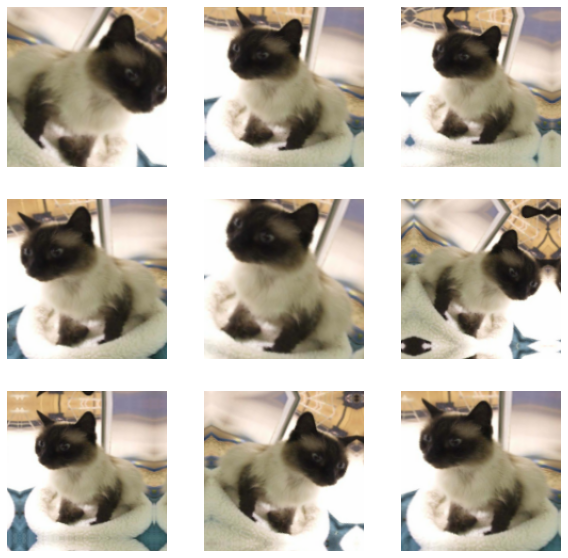

In [64]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [65]:
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [66]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100


313/313 [==============================] - 61s 181ms/step - loss: 0.6939 - accuracy: 0.4951 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/100
313/313 [==============================] - 56s 179ms/step - loss: 0.6916 - accuracy: 0.5168 - val_loss: 0.6763 - val_accuracy: 0.5820
Epoch 3/100
313/313 [==============================] - 57s 181ms/step - loss: 0.6743 - accuracy: 0.5843 - val_loss: 0.6524 - val_accuracy: 0.6390
Epoch 4/100
313/313 [==============================] - 56s 180ms/step - loss: 0.6393 - accuracy: 0.6424 - val_loss: 0.6006 - val_accuracy: 0.6840
Epoch 5/100
313/313 [==============================] - 56s 178ms/step - loss: 0.6165 - accuracy: 0.6588 - val_loss: 0.5945 - val_accuracy: 0.6860
Epoch 6/100
313/313 [==============================] - 57s 180ms/step - loss: 0.5908 - accuracy: 0.6885 - val_loss: 0.5555 - val_accuracy: 0.7230
Epoch 7/100
313/313 [==============================] - 58s 183ms/step - loss: 0.5695 - accuracy: 0.7076 - val_loss: 0.5620 - val_accurac

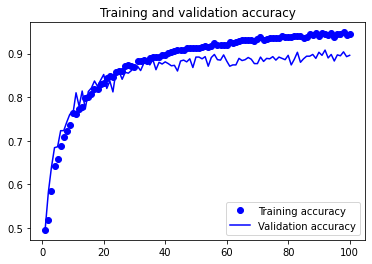

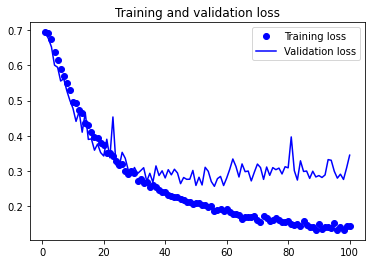

In [67]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [68]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 26ms/step - loss: 0.2679 - accuracy: 0.8950
Test accuracy: 0.895
